# 🔍 Práctica 5: Missing Data Detective - Fill in the Blanks

## UT2: Calidad & Ética | Práctica Guiada

### 🎯 Objetivos Básicos

- Aprender a detectar y analizar datos faltantes (MCAR, MAR, MNAR)
- Identificar outliers usando métodos estadísticos
- Implementar estrategias de imputación apropiadas
- Crear pipelines de limpieza reproducibles
- Considerar aspectos éticos en el tratamiento de datos

### 📋 Lo que necesitas saber ANTES de empezar

- Conceptos básicos de pandas y visualización
- Idea general de qué son los datos faltantes
- Curiosidad por entender patrones en la calidad de datos

## 🔍 Parte 1: Setup y Carga de Datos¶

### 📋 CONTEXTO DE NEGOCIO (CRISP-DM: Business Understanding)

### 🔗 Referencias oficiales:

- [Kaggle Data Cleaning - Handling Missing Values](https://www.kaggle.com/learn/data-cleaning/lesson/1)
- [Pandas Documentation](https://pandas.pydata.org/docs/)
- [Matplotlib Documentation](https://matplotlib.org/stable/users/index.html)
- [Seaborn Documentation](https://seaborn.pydata.org)
- [Scikit-learn Documentation](https://scikit-learn.org/stable/)

### 🏠 Caso de negocio:

- Problema: El dataset Ames Housing tiene datos faltantes y outliers que afectan las predicciones de precios
- Objetivo: Detectar patrones de missing data y outliers para limpiar el dataset
- Variables: SalePrice, LotArea, YearBuilt, GarageArea, Neighborhood, HouseStyle, etc.
- Valor para el negocio: Datos más limpios = predicciones de precios más confiables

In [1]:
# === SETUP DEL ENTORNO ===

# 1. Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
from pandas.api.types import is_numeric_dtype
warnings.filterwarnings('ignore')

print("✅ Todas las librerías importadas correctamente")

# 3. Configurar visualizaciones
plt.style.use('default')  # estilo visual (ej: 'seaborn-v0_8', 'default', 'classic')
sns.set_palette("husl")  # paleta de colores (ej: 'husl', 'Set1', 'viridis')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("🎨 Configuración de visualizaciones lista!")

✅ Todas las librerías importadas correctamente
🎨 Configuración de visualizaciones lista!


## 🏠 Paso 2: Cargar y Crear Missing Data Sintético

In [2]:
# === CARGAR DATASET AMES HOUSING ===

# 1. Cargar dataset base
!curl -L -o ames-housing-dataset.zip https://www.kaggle.com/api/v1/datasets/download/shashanknecrothapa/ames-housing-dataset
!unzip ames-housing-dataset.zip
df = pd.read_csv('AmesHousing.csv')


print("🏠 DATASET: Ames Housing")
print(f"   📊 Forma original: {df.shape}")
print(f"   📋 Columnas: {list(df.columns)}")

# 2. Crear missing data sintético para práctica
np.random.seed(42)  # para reproducibilidad

# Simular MCAR en Year Built (8% missing aleatorio)
# "Los valores faltan al azar: que falte un Year Built no depende de la edad ni del propio Year Built"
missing_year = np.random.random(len(df)) < 0.08
df.loc[missing_year, 'Year Built'] = np.nan

# Simular MAR en Garage Area (missing relacionado con Garage Type)
# "Los faltantes de Garage Area se concentran en ciertos tipos de garaje (variable observada)"
df.loc[df['Garage Type'] == 'None', 'Garage Area'] = df.loc[df['Garage Type'] == 'None', 'Garage Area'].sample(frac=0.7, random_state=42)

# Simular MNAR en SalePrice (missing relacionado con precio alto)
# "Los faltantes dependen del propio valor: quienes tienen precios altos no reportan precio"
high_price = df['SalePrice'] > df['SalePrice'].quantile(0.85)
df.loc[high_price, 'SalePrice'] = df.loc[high_price, 'SalePrice'].sample(frac=0.2, random_state=42)

print("\n🔍 Missing data sintético creado:")
print(df.isnull().sum())  # método para contar valores faltantes por columna

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  184k  100  184k    0     0  99911      0  0:00:01  0:00:01 --:--:--  270k
Archive:  ames-housing-dataset.zip
  inflating: AmesHousing.csv         
🏠 DATASET: Ames Housing
   📊 Forma original: (2930, 82)
   📋 Columnas: ['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area', 'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 

## 📊 Paso 3: Análisis Inicial del Dataset

In [3]:
# === EXPLORACIÓN BÁSICA ===

# 1. Información general del dataset
print("=== INFORMACIÓN GENERAL ===")
print(df.info())  # método que muestra tipos de datos, memoria y valores no nulos

# 2. Estadísticas descriptivas
print("\n=== ESTADÍSTICAS DESCRIPTIVAS ===")
print(df.describe())  # método que calcula estadísticas descriptivas

# 3. Tipos de datos
print("\n=== TIPOS DE DATOS ===")
print(df.dtypes)  # atributo que muestra tipos de datos por columna

# 4. Verificar missing data
print("\n=== MISSING DATA POR COLUMNA ===")
missing_count = df.isnull().sum()  # contar valores faltantes
missing_pct = (missing_count / len(df)) * 100  # calcular porcentaje

missing_stats = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': missing_count,
    'Missing_Percentage': missing_pct
})
print(missing_stats[missing_stats['Missing_Count'] > 0])

# 5. Análisis de memoria
print("\n=== ANÁLISIS DE MEMORIA ===")
total_bytes = df.memory_usage(deep=True).sum()  # método para memoria en bytes
print(f"Memoria total del DataFrame: {total_bytes / (1024**2):.2f} MB")
print(f"Memoria por columna:")
for col in df.columns:
    memory_usage = df[col].memory_usage()  # método para memoria de una columna
    print(f"  {col}: {memory_usage / 1024:.2f} KB")

# 6. Análisis de duplicados
print("\n=== ANÁLISIS DE DUPLICADOS ===")
duplicates = df.duplicated()  # método para detectar filas duplicadas
print(f"Número de filas duplicadas: {duplicates.sum()}")
if duplicates.sum() > 0:
    print("Primeras 5 filas duplicadas:")
    print(df[df.duplicated()].head())  # método para filtrar duplicados

=== INFORMACIÓN GENERAL ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null  

## 🔍 Paso 4: Detección de Patrones de Missing Data

Columnas con missing data: 29
Columnas: ['Lot Frontage', 'Alley', 'Year Built', 'Mas Vnr Type', 'Mas Vnr Area', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Electrical', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence', 'Misc Feature', 'SalePrice']


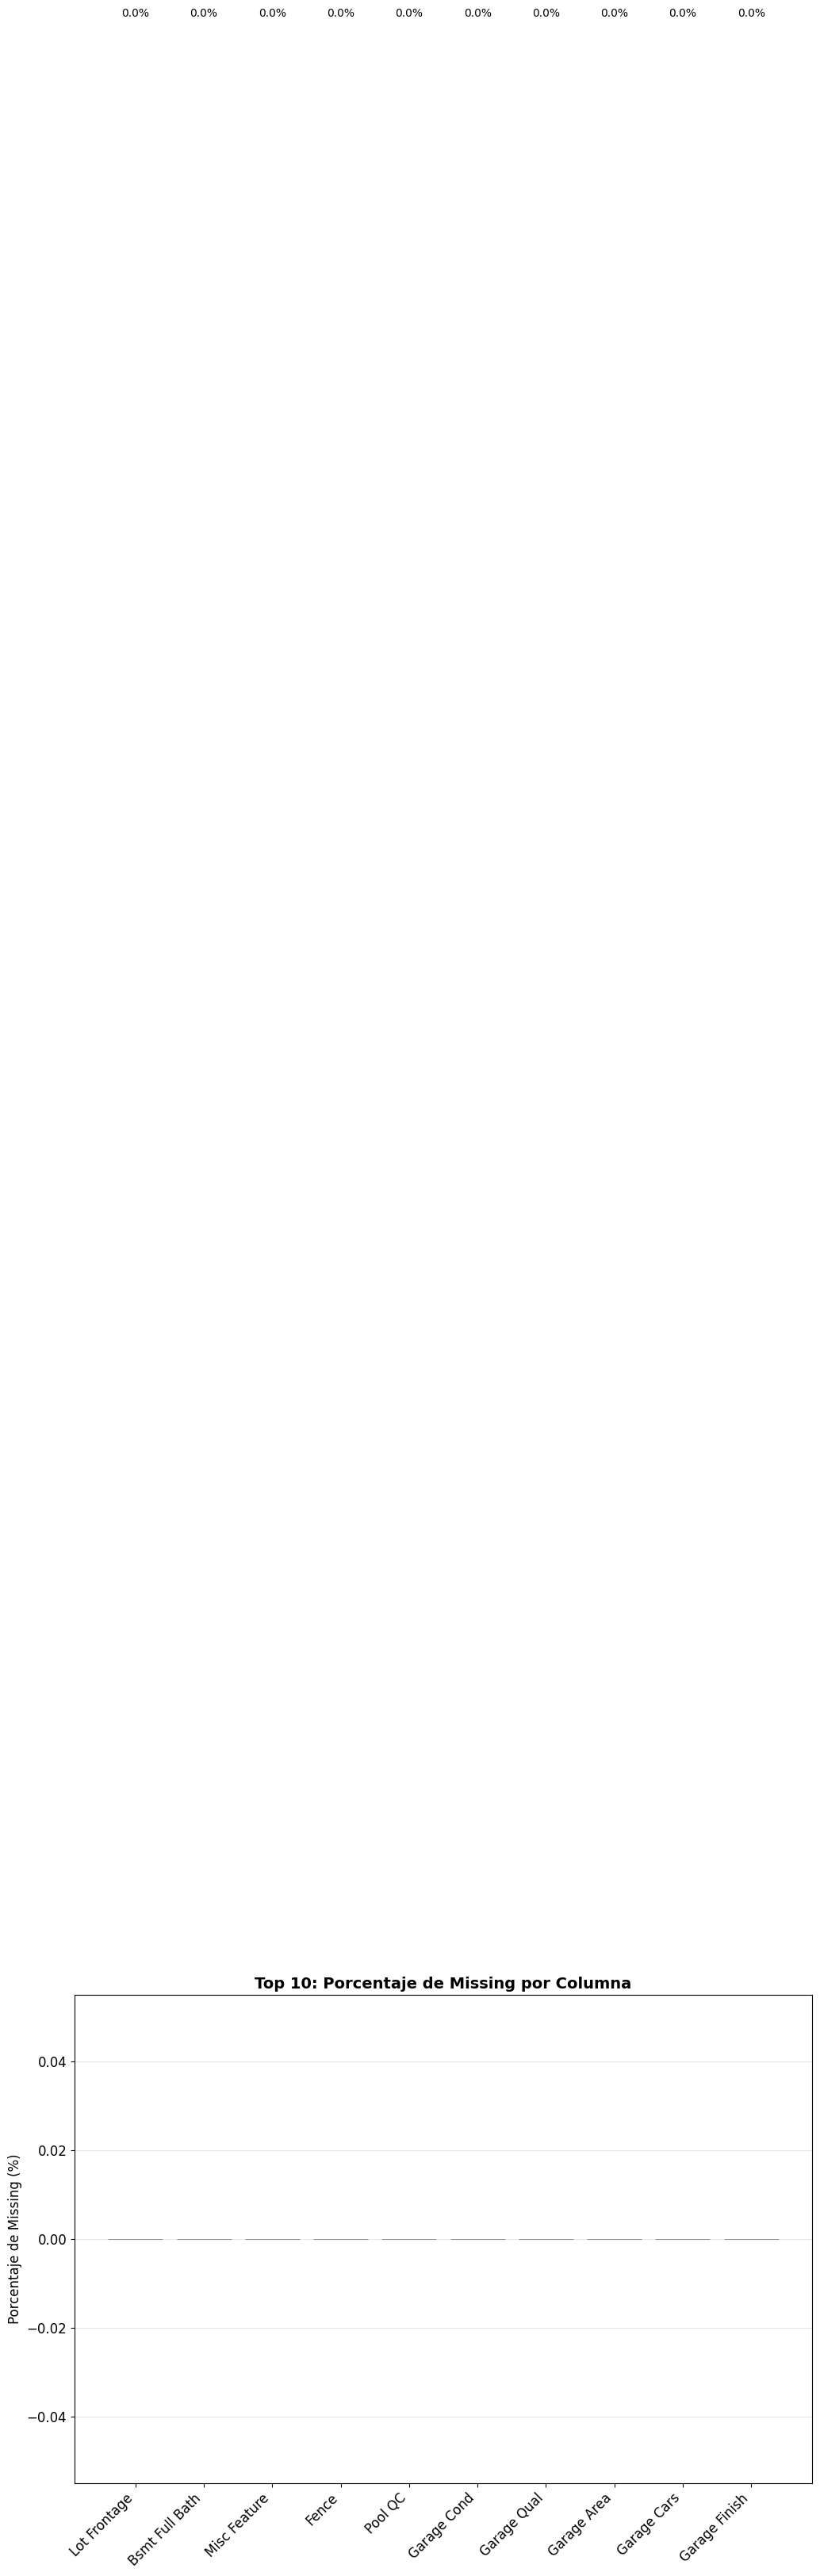

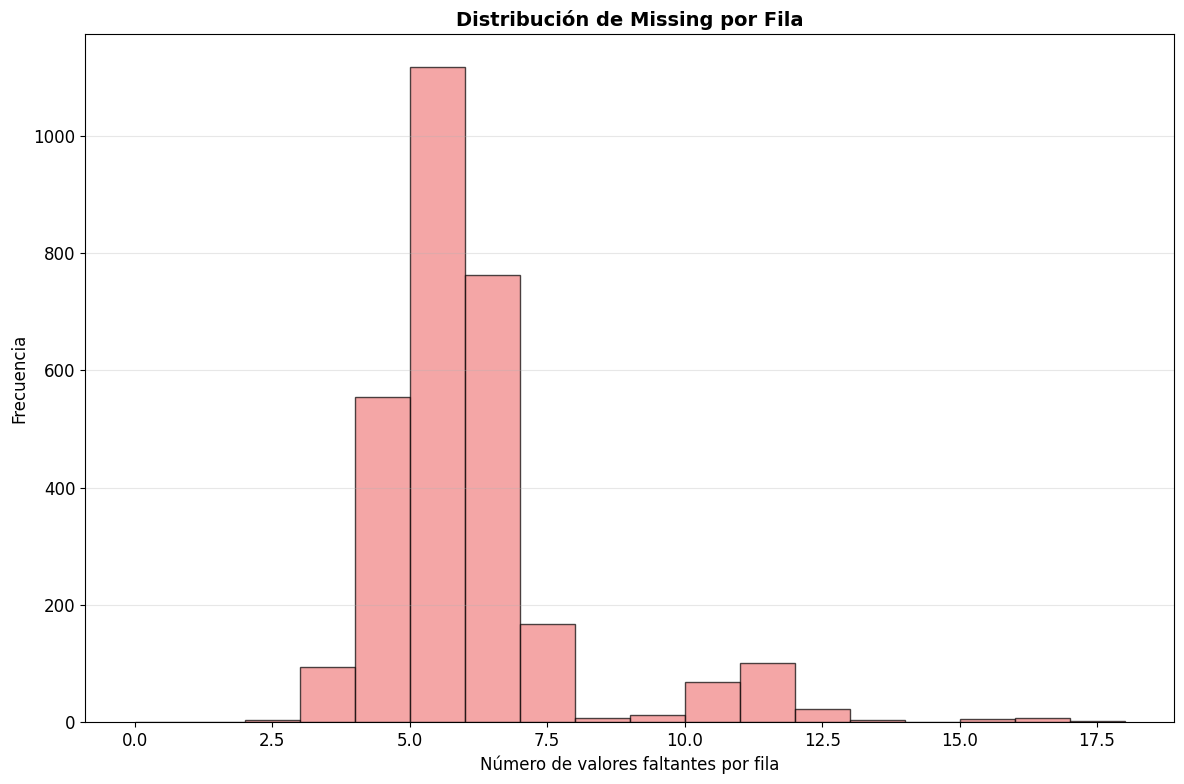

In [5]:
# === ANÁLISIS DE PATRONES DE MISSING DATA ===

# 1. Filtrar solo columnas con missing data para visualización
missing_columns = df.columns[df.isnull().any()].tolist()  # método para detectar missing
print(f"Columnas con missing data: {len(missing_columns)}")
print(f"Columnas: {missing_columns}")

# 2. Visualización mejorada sin missingno
plt.subplot(1, 1, 1)
if len(missing_columns) > 0:
    # Crear estadísticas de missing solo para columnas con missing data
    missing_count = df[missing_columns].value_counts().sum()  # método para contar missing
    missing_pct = (missing_count / len(df)) * 100  # calcular porcentaje

    missing_stats_filtered = pd.DataFrame({
        'Column': missing_columns,
        'Missing_Count': missing_count,
        'Missing_Percentage': missing_pct
    }).sort_values('Missing_Percentage', ascending=False).head(10)

    # Crear gráfico de barras más limpio
    bars = plt.bar(range(len(missing_stats_filtered)), missing_stats_filtered['Missing_Percentage'], 
                   color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)  # función para barras
    plt.title('Top 10: Porcentaje de Missing por Columna', fontsize=14, fontweight='bold')
    plt.xticks(range(len(missing_stats_filtered)), missing_stats_filtered['Column'], 
               rotation=45, ha='right')  # función para etiquetas del eje X

    plt.ylabel('Porcentaje de Missing (%)')
    plt.grid(True, alpha=0.3, axis='y')

    # Agregar valores en las barras
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=10)
else:
    plt.text(0.5, 0.5, 'No hay missing data', ha='center', va='center', fontsize=16)
    plt.title('Porcentaje de Missing por Columna', fontsize=14, fontweight='bold')

# Distribución de missing por fila
plt.show()
plt.subplot(1, 1, 1)
missing_per_row = df.isnull().sum(axis=1)  # contar missing por fila
plt.hist(missing_per_row, bins=range(0, missing_per_row.max()+2), alpha=0.7, 
         edgecolor='black', color='lightcoral')  # función para histograma
plt.title('Distribución de Missing por Fila', fontsize=14, fontweight='bold')
plt.xlabel('Número de valores faltantes por fila')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
!mkdir -p results/visualizaciones
plt.savefig('results/visualizaciones/missing_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

## 🧠 Paso 5: Clasificar Tipos de Missing Data

In [7]:
# === CLASIFICACIÓN MCAR/MAR/MNAR ===

print("=== ANÁLISIS DE TIPOS DE MISSING ===")

# 1. Year Built: ¿MCAR o MAR?
print("\n1. YEAR BUILT - Análisis de patrones:")
year_missing = df['Year Built'].isnull()  # método para detectar missing
print("Missing Year Built por Neighborhood:")
print(df.groupby('Neighborhood')['Year Built'].apply(lambda x: x.isnull().sum()))  # contar missing por grupo

print("Missing Year Built por House Style:")
print(df.groupby('House Style')['Year Built'].apply(lambda x: x.isnull().sum()))

# 2. Garage Area: ¿MAR?
print("\n2. GARAGE AREA - Análisis de patrones:")
print("Missing Garage Area por Garage Type:")
print(df.groupby('Garage Type')['Garage Area'].apply(lambda x: x.isnull().sum()))

# 3. SalePrice: ¿MNAR?
print("\n3. SALEPRICE - Análisis de patrones:")
price_missing = df['SalePrice'].isnull()
print("Valores de SalePrice en registros con missing:")
print(df[price_missing]['SalePrice'].describe())  # estadísticas descriptivas

=== ANÁLISIS DE TIPOS DE MISSING ===

1. YEAR BUILT - Análisis de patrones:
Missing Year Built por Neighborhood:
Neighborhood
Blmngtn     4
Blueste     0
BrDale      3
BrkSide    13
ClearCr     3
CollgCr    22
Crawfor    11
Edwards    20
Gilbert    15
Greens      0
GrnHill     0
IDOTRR      7
Landmrk     0
MeadowV     4
Mitchel    14
NAmes      38
NPkVill     2
NWAmes     14
NoRidge     3
NridgHt    15
OldTown    18
SWISU       7
Sawyer      9
SawyerW     6
Somerst    17
StoneBr     5
Timber      4
Veenker     2
Name: Year Built, dtype: int64
Missing Year Built por House Style:
House Style
1.5Fin     28
1.5Unf      2
1Story    136
2.5Fin      0
2.5Unf      3
2Story     67
SFoyer      6
SLvl       14
Name: Year Built, dtype: int64

2. GARAGE AREA - Análisis de patrones:
Missing Garage Area por Garage Type:
Garage Type
2Types     0
Attchd     0
Basment    0
BuiltIn    0
CarPort    0
Detchd     1
Name: Garage Area, dtype: int64

3. SALEPRICE - Análisis de patrones:
Valores de SalePrice en

## 🚨 Paso 6: Detección de Outliers

In [9]:
# === DETECCIÓN DE OUTLIERS CON IQR ===
# "Detectar extremos usando mediana y cuartiles"
# "Cuándo usar: distribuciones asimétricas / colas pesadas / presencia de outliers"
if "Year Built" in df.columns:
    df["Year Built"] = pd.to_numeric(df["Year Built"], errors="coerce")

# === DETECCIÓN DE OUTLIERS: IQR y Z-SCORE (robustas) ===
def detect_outliers_iqr(df, column, factor=1.5):
    """Outliers por IQR. Devuelve (df_outliers, lower, upper)."""
    x = pd.to_numeric(df[column], errors="coerce")
    x_no_na = x.dropna().astype(float).values
    if x_no_na.size == 0:
        # sin datos válidos
        return df.iloc[[]], np.nan, np.nan
    q1 = np.percentile(x_no_na, 25)
    q3 = np.percentile(x_no_na, 75)
    iqr = q3 - q1
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    mask = (pd.to_numeric(df[column], errors="coerce") < lower) | (pd.to_numeric(df[column], errors="coerce") > upper)
    return df[mask], lower, upper

# Analizar outliers en columnas numéricas
numeric_columns = df.select_dtypes(include=[np.number]).columns  # método para seleccionar columnas numéricas
outlier_analysis = {}

for col in numeric_columns:
    if not df[col].isnull().all():  # método para verificar si hay missing data
        outliers, lower, upper = detect_outliers_iqr(df, col)
        outlier_analysis[col] = {
            'count': len(outliers),
            'percentage': (len(outliers) / len(df)) * 100,
            'lower_bound': lower,
            'upper_bound': upper
        }

outlier_df = pd.DataFrame(outlier_analysis).T
print("=== ANÁLISIS DE OUTLIERS (IQR) ===")
print("Útil cuando la distribución está chueca o con colas largas")
print(outlier_df)

# Análisis adicional de outliers
print("\n=== RESUMEN DE OUTLIERS ===")
total_outliers = outlier_df['count'].sum()  # método para sumar outliers
print(f"Total de outliers detectados: {total_outliers}")
print(f"Porcentaje promedio de outliers: {outlier_df['percentage'].mean():.2f}%")  # método para calcular media
print(f"Columna con más outliers: {outlier_df['count'].idxmax()}")  # método para encontrar máximo

=== ANÁLISIS DE OUTLIERS (IQR) ===
Útil cuando la distribución está chueca o con colas largas
                 count  percentage   lower_bound   upper_bound
Order              0.0    0.000000 -1.463500e+03  4.394500e+03
PID                0.0    0.000000 -3.957909e+07  1.475237e+09
MS SubClass      208.0    7.098976 -5.500000e+01  1.450000e+02
Lot Frontage     187.0    6.382253  2.500000e+01  1.130000e+02
Lot Area         127.0    4.334471  1.267750e+03  1.772775e+04
Overall Qual       4.0    0.136519  2.000000e+00  1.000000e+01
Overall Cond     252.0    8.600683  3.500000e+00  7.500000e+00
Year Built         8.0    0.273038  1.885000e+03  2.069000e+03
Year Remod/Add     0.0    0.000000  1.906500e+03  2.062500e+03
Mas Vnr Area     200.0    6.825939 -2.460000e+02  4.100000e+02
BsmtFin SF 1      15.0    0.511945 -1.101000e+03  1.835000e+03
BsmtFin SF 2     351.0   11.979522  0.000000e+00  0.000000e+00
Bsmt Unf SF       56.0    1.911263 -6.555000e+02  1.676500e+03
Total Bsmt SF    123.0  

## 🔍 Paso 7: Detección de Outliers con Z-Score

In [10]:
# === DETECCIÓN DE OUTLIERS CON Z-SCORE ===
# "Cuándo usar: distribución aprox. campana y sin colas raras"
# "Regla: 3 pasos (desvios) desde el promedio = raro"

def detect_outliers_zscore(df, column, threshold=3):
    """Detectar outliers usando Z-Score - Regla: 3 desvios desde el promedio = raro"""
    from scipy import stats
    z_scores = np.abs(stats.zscore(df[column].dropna()))
    outlier_indices = df[column].dropna().index[z_scores > threshold]
    return df.loc[outlier_indices]

# Comparar métodos de detección
print("\n=== COMPARACIÓN DE MÉTODOS DE DETECCIÓN ===")
for col in ['SalePrice', 'Lot Area', 'Year Built', 'Garage Area']:
    if col in df.columns and not df[col].isnull().all():
        iqr_outliers = detect_outliers_iqr(df, col)
        zscore_outliers = detect_outliers_zscore(df, col)

        print(f"\n{col}:")
        print(f"  IQR outliers: {len(iqr_outliers[0])} ({len(iqr_outliers[0])/len(df)*100:.1f}%)")
        print(f"  Z-Score outliers: {len(zscore_outliers)} ({len(zscore_outliers)/len(df)*100:.1f}%)")


=== COMPARACIÓN DE MÉTODOS DE DETECCIÓN ===

SalePrice:
  IQR outliers: 55 (1.9%)
  Z-Score outliers: 29 (1.0%)

Lot Area:
  IQR outliers: 127 (4.3%)
  Z-Score outliers: 29 (1.0%)

Year Built:
  IQR outliers: 8 (0.3%)
  Z-Score outliers: 7 (0.2%)

Garage Area:
  IQR outliers: 42 (1.4%)
  Z-Score outliers: 17 (0.6%)


## 📊 Paso 8: Visualización de Outliers

In [14]:
import os

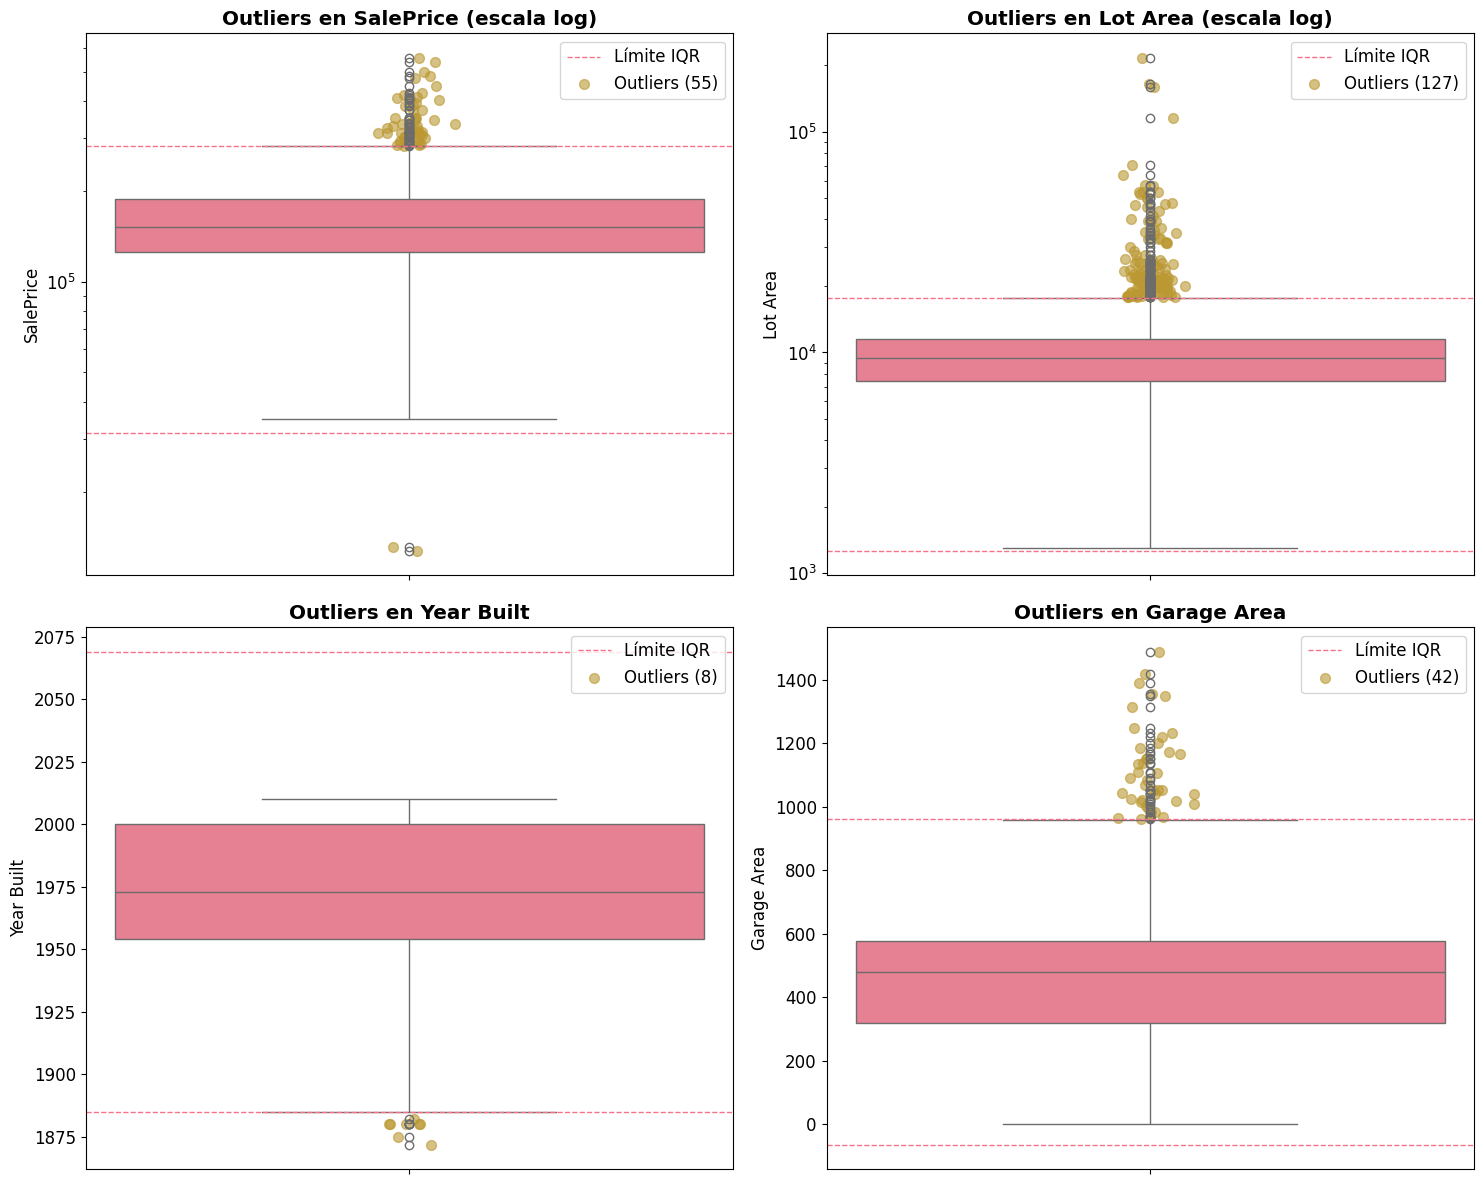

In [15]:
# === VISUALIZAR OUTLIERS ===
os.makedirs('results/visualizaciones', exist_ok=True)

cols = ['SalePrice', 'Lot Area', 'Year Built', 'Garage Area']

fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # función para crear subplots
axes = axes.flatten()  # método para aplanar array

for i, col in enumerate(cols):
    if col not in df.columns:
        axes[i].set_visible(False)
        continue

    # convertir a numérico de forma segura
    y = pd.to_numeric(df[col], errors='coerce').dropna()

    if y.empty:
        axes[i].axis('off')
        axes[i].text(0.5, 0.5, f"{col}: sin datos numéricos", ha='center', va='center', fontsize=11)
        continue

    # Boxplot usando el vector numérico (evita inferencias de dtype de seaborn)
    sns.boxplot(y=y, ax=axes[i])  # función para boxplot
    axes[i].set_title(f'Outliers en {col}', fontweight='bold')
    axes[i].set_ylabel(col)

    # Outliers por IQR y bandas
    iqr_df, lower, upper = detect_outliers_iqr(df, col)
    out_vals = pd.to_numeric(iqr_df[col], errors='coerce').dropna()

    if np.isfinite(lower):
        axes[i].axhline(lower, linestyle='--', linewidth=1, label='Límite IQR')
    if np.isfinite(upper):
        axes[i].axhline(upper, linestyle='--', linewidth=1)

    # Marcar outliers con un leve jitter en X para que se vean
    if len(out_vals) > 0:
        jitter_x = np.random.normal(loc=0, scale=0.02, size=len(out_vals))
        axes[i].scatter(jitter_x, out_vals, alpha=0.6, s=50, label=f'Outliers ({len(out_vals)})') # función para scatter
        axes[i].legend()  # método para mostrar leyenda

    # Opcional: si la variable es muy sesgada, usar escala log
    if col in ['Lot Area', 'SalePrice'] and y.skew() > 1:
        axes[i].set_yscale('log')
        axes[i].set_title(f'Outliers en {col} (escala log)', fontweight='bold')

plt.tight_layout() # función para ajustar layout
plt.savefig('results/visualizaciones/outliers_analysis.png', dpi=300, bbox_inches='tight') # función para guardar
plt.show() # función para mostrar gráfico

## 🔧 Paso 9: Estrategias de Imputación

In [12]:
# === IMPLEMENTAR ESTRATEGIAS DE IMPUTACIÓN ===
# "Rellenar no es gratis; hacelo columna a columna y documentá"
# "Num: mediana (si cola pesada) / media (si ~normal)"
# "Cat: moda o 'Unknown' (+ flag si sospecha MNAR)"

def impute_missing_data(df, strategy='median'):
    """Implementar diferentes estrategias de imputación - Reglas simples de la clase"""
    df_imputed = df.copy()

    for col in df.columns:
        if df[col].isnull().any():
            if df[col].dtype in ['int64', 'float64']:
                if strategy == 'mean':
                    df_imputed[col].fillna(df[col].mean(), inplace=True)  # imputar con media
                elif strategy == 'median':
                    df_imputed[col].fillna(df[col].median(), inplace=True)  # imputar con mediana
                elif strategy == 'mode':
                    df_imputed[col].fillna(df[col].mode()[0], inplace=True)  # imputar con moda
            else:
                # Para variables categóricas
                df_imputed[col].fillna(df[col].mode()[0], inplace=True)  # imputar con moda

    return df_imputed

# Probar diferentes estrategias
strategies = ['mean', 'median', 'mode']
imputed_datasets = {}

for strategy in strategies:
    imputed_datasets[strategy] = impute_missing_data(df, strategy)
    print(f"Estrategia {strategy}: {imputed_datasets[strategy].isnull().sum().sum()} missing values restantes")

Estrategia mean: 0 missing values restantes
Estrategia median: 0 missing values restantes
Estrategia mode: 0 missing values restantes


## 🧠 Paso 10: Imputación Inteligente por Tipo de Missing

In [16]:
def smart_imputation(df, *, impute_saleprice=True):
    """Imputación inteligente robusta a dtypes y NaN."""
    df_imputed = df.copy()

    # --- 0) Asegurar dtypes numéricos donde corresponde ---
    for c in ["Year Built", "Garage Area", "SalePrice"]:
        if c in df_imputed.columns:
            df_imputed[c] = pd.to_numeric(df_imputed[c], errors="coerce")  # to_numeric

    # --- 1) Year Built: mediana por (Neighborhood, House Style) -> Neighborhood -> global ---
    if {"Neighborhood", "House Style", "Year Built"}.issubset(df_imputed.columns):
        grp_med = df_imputed.groupby(["Neighborhood", "House Style"])["Year Built"].transform("median")  # groupby, transform
        df_imputed["Year Built"] = df_imputed["Year Built"].fillna(grp_med)  # fillna

        nb_med = df_imputed.groupby("Neighborhood")["Year Built"].transform("median")
        df_imputed["Year Built"] = df_imputed["Year Built"].fillna(nb_med)

        df_imputed["Year Built"] = df_imputed["Year Built"].fillna(df_imputed["Year Built"].median( ))  # median
        # Año entero nullable
        df_imputed["Year Built"] = df_imputed["Year Built"].round( ).astype("Int64")  # round

    # --- 2) Garage Area: MNAR → indicador + 0; resto por mediana del barrio ---
    if "Garage Area" in df_imputed.columns:
        df_imputed["GarageArea_was_na"] = df_imputed["Garage Area"].isna( ).astype("Int8")  # isna

        # Si hay "Garage Cars", usarlo para inferir "sin garaje" (0 área)
        if "Garage Cars" in df_imputed.columns:
            no_garage_mask = (df_imputed["Garage Cars"].fillna(0) == 0) & df_imputed["Garage Area"].isna()
            df_imputed.loc[no_garage_mask, "Garage Area"] = 0.0

        # Para los NaN restantes: mediana por Neighborhood, luego global
        if "Neighborhood" in df_imputed.columns:
            med_gar = df_imputed.groupby("Neighborhood")["Garage Area"].transform("median")
            df_imputed["Garage Area"] = df_imputed["Garage Area"].fillna(med_gar)

        df_imputed["Garage Area"] = df_imputed["Garage Area"].fillna(df_imputed["Garage Area"].median())

    # --- 3) SalePrice: mediana por Neighborhood (opcional) ---
    if impute_saleprice and {"Neighborhood", "SalePrice"}.issubset(df_imputed.columns):
        nb_price = df_imputed.groupby("Neighborhood")["SalePrice"].transform("median")
        df_imputed["SalePrice"] = df_imputed["SalePrice"].fillna(nb_price)  # fillna
        df_imputed["SalePrice"] = df_imputed["SalePrice"].fillna(df_imputed["SalePrice"].median())

    # --- 4) Garage Type: moda global (MCAR); manejar categorías ---
    if "Garage Type" in df_imputed.columns:
        # evitar problemas si es category
        if pd.api.types.is_categorical_dtype(df_imputed["Garage Type"]):  # is_categorical_dtype
            df_imputed["Garage Type"] = df_imputed["Garage Type"].astype("object")
        mode_val = df_imputed["Garage Type"].dropna().mode( )  # mode
        fill_val = mode_val.iloc[0] if not mode_val.empty else "Unknown"
        df_imputed["Garage Type"] = df_imputed["Garage Type"].fillna(fill_val)  # fillna

    return df_imputed

# Aplicar
df_smart_imputed = smart_imputation(df)
print("=== IMPUTACIÓN INTELIGENTE ===")
print(f"Missing restantes: {int(df_smart_imputed.isnull().sum().sum())}")

=== IMPUTACIÓN INTELIGENTE ===
Missing restantes: 15591


## 🚫 Paso 11: Anti-Leakage Básico

In [17]:
# === ANTI-LEAKAGE BÁSICO ===
# "No espiés el examen: fit en TRAIN, transform en VALID/TEST"
# "Split: X_train / X_valid / X_test"
# "imputer.fit(X_train) → transform al resto"

from sklearn.model_selection import train_test_split

# 1. Split de datos (ANTES de imputar)
X = df.drop('SalePrice', axis=1)  # features
y = df['SalePrice']  # target

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("=== SPLIT DE DATOS ===")
print(f"Train: {X_train.shape[0]} registros")
print(f"Valid: {X_valid.shape[0]} registros") 
print(f"Test: {X_test.shape[0]} registros")

# 2. Imputar SOLO en train, luego transformar
from sklearn.impute import SimpleImputer

# Separar columnas numéricas y categóricas
numeric_columns = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Columnas numéricas: {len(numeric_columns)}")
print(f"Columnas categóricas: {len(categorical_columns)}")

# Crear imputers para cada tipo de dato
numeric_imputer = SimpleImputer(strategy='median')  # estrategia para numéricas
categorical_imputer = SimpleImputer(strategy='most_frequent')  # estrategia para categóricas

# Ajustar imputers SOLO con train
numeric_imputer.fit(X_train[numeric_columns])  # ajustar numéricas
categorical_imputer.fit(X_train[categorical_columns])  # ajustar categóricas

# Transformar todos los conjuntos
X_train_numeric = numeric_imputer.transform(X_train[numeric_columns])  # transformar numéricas
X_train_categorical = categorical_imputer.transform(X_train[categorical_columns])  # transformar categóricas

X_valid_numeric = numeric_imputer.transform(X_valid[numeric_columns])
X_valid_categorical = categorical_imputer.transform(X_valid[categorical_columns])

X_test_numeric = numeric_imputer.transform(X_test[numeric_columns])
X_test_categorical = categorical_imputer.transform(X_test[categorical_columns])

print("\n✅ Anti-leakage aplicado: fit solo en train, transform en todo")

=== SPLIT DE DATOS ===
Train: 1758 registros
Valid: 586 registros
Test: 586 registros
Columnas numéricas: 38
Columnas categóricas: 43

✅ Anti-leakage aplicado: fit solo en train, transform en todo


## 📊 Paso 12: Análisis de Impacto de la Imputación

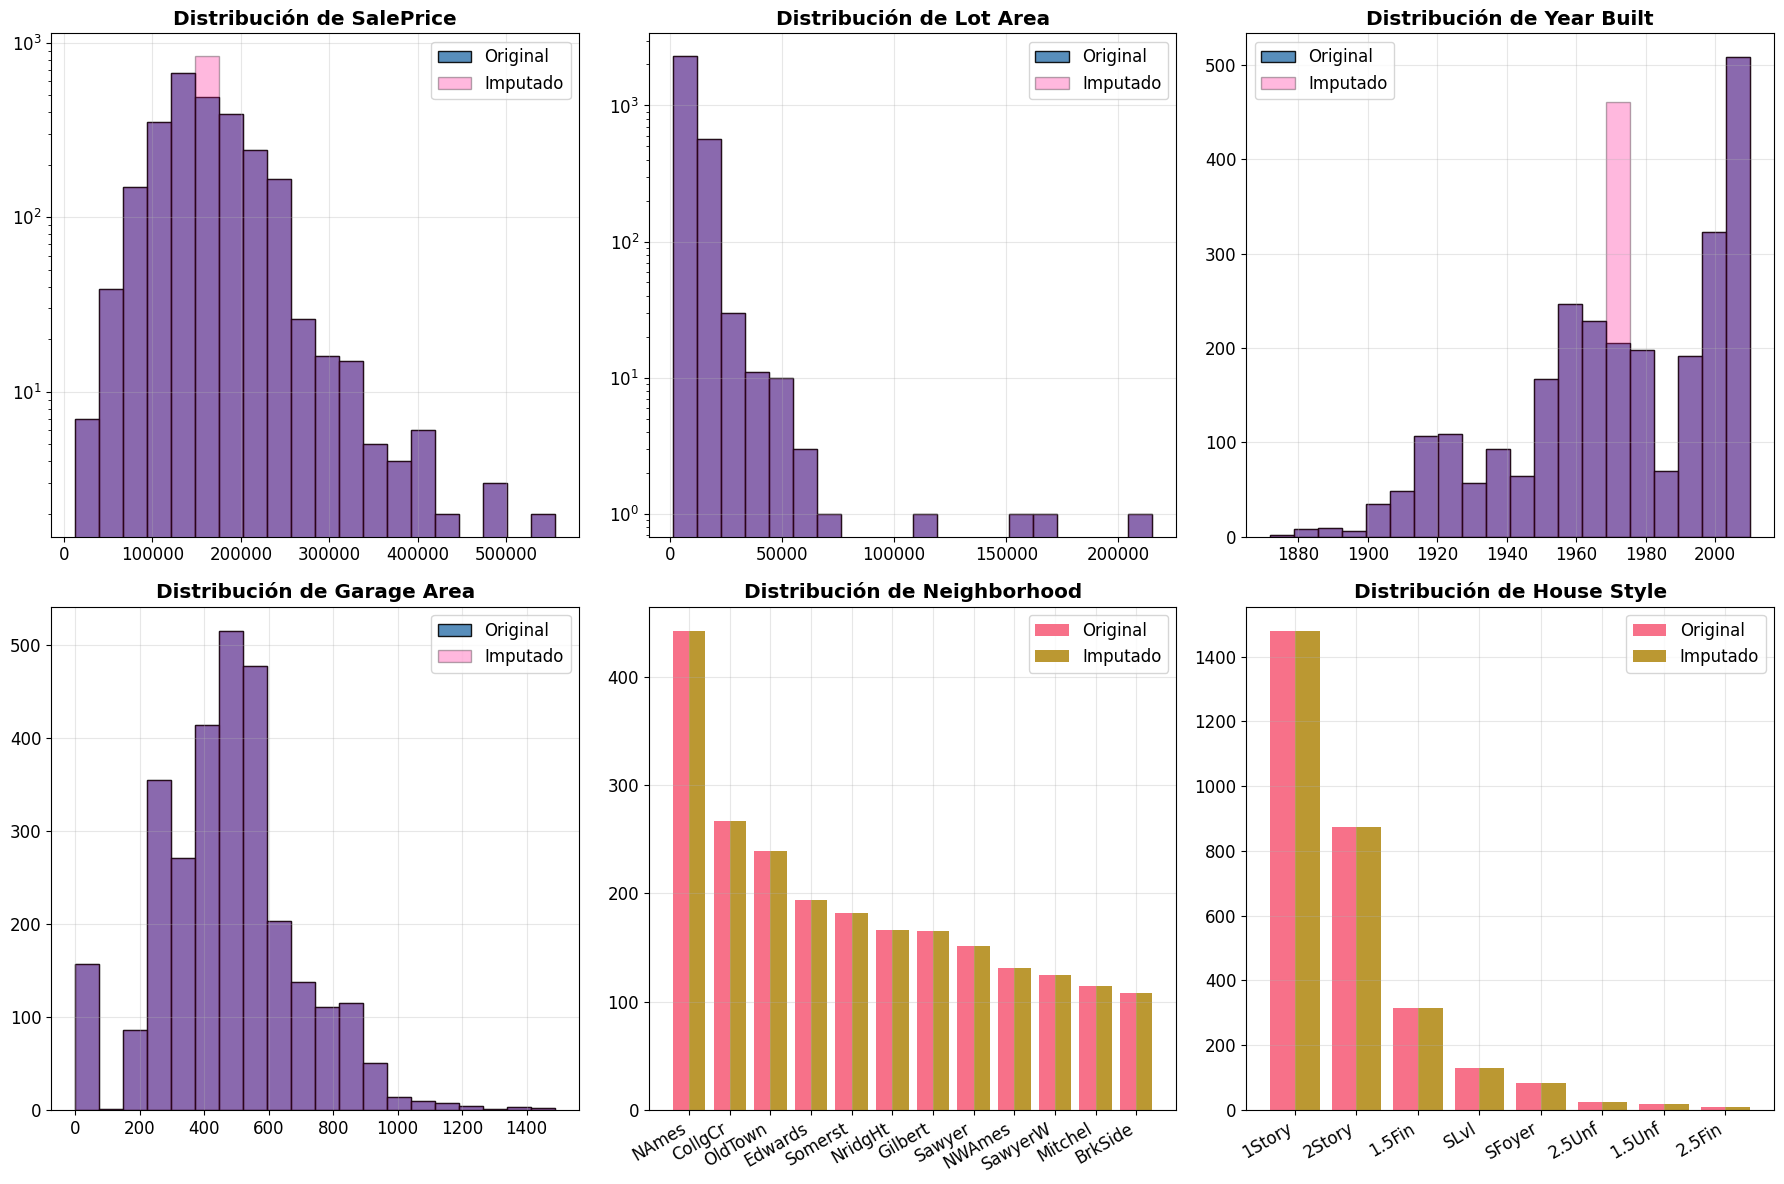

Columnas seleccionadas para correlaciones: ['SalePrice', 'Lot Area', 'Year Built', 'Garage Area', 'Overall Qual', 'Gr Liv Area', 'Total Bsmt SF']


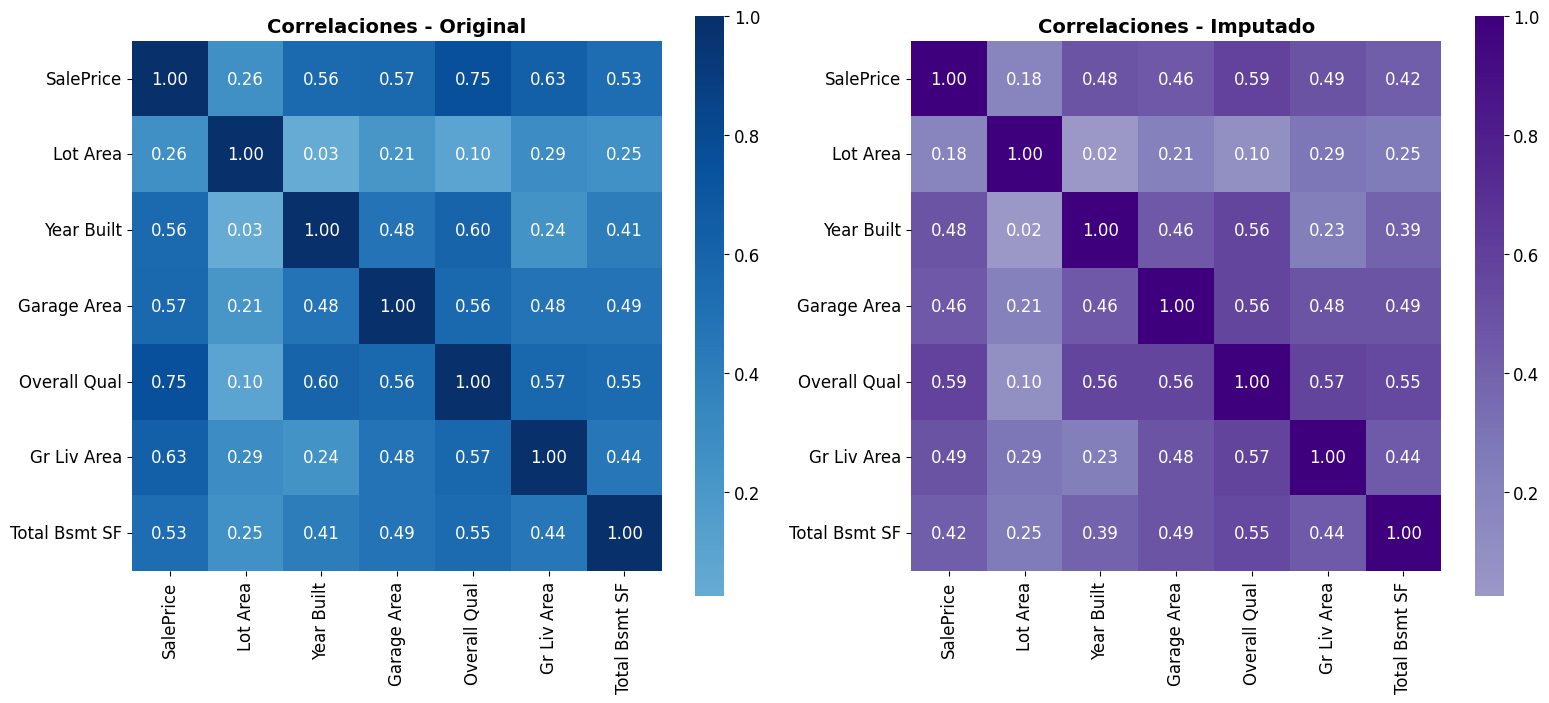


=== DIFERENCIAS EN CORRELACIONES ===
Cambios en correlaciones (Imputado - Original):
               SalePrice  Lot Area  Year Built  Garage Area  Overall Qual  \
SalePrice          0.000    -0.074      -0.078       -0.105        -0.165   
Lot Area          -0.074     0.000      -0.001       -0.000         0.000   
Year Built        -0.078    -0.001       0.000       -0.022        -0.031   
Garage Area       -0.105    -0.000      -0.022        0.000        -0.000   
Overall Qual      -0.165     0.000      -0.031       -0.000         0.000   
Gr Liv Area       -0.141     0.000      -0.010       -0.000         0.000   
Total Bsmt SF     -0.103     0.000      -0.018       -0.000        -0.000   

               Gr Liv Area  Total Bsmt SF  
SalePrice           -0.141         -0.103  
Lot Area             0.000          0.000  
Year Built          -0.010         -0.018  
Garage Area         -0.000         -0.000  
Overall Qual         0.000         -0.000  
Gr Liv Area          0.000       

In [22]:
# 1) Crear df_imputed con imputación simple, robusta a dtypes
df_imputed = df.copy()

for col in df.columns:
    s = df[col]
    # Si es numérica o puede convertirse a numérica, imputar mediana
    if is_numeric_dtype(s) or (s.dtype == "object"):
        s_num = pd.to_numeric(s, errors="coerce")
        if s_num.notna().any():
            df_imputed[col] = s_num.fillna(s_num.median()) # imputar numéricas con mediana
            continue
    # Caso categórico: imputar con moda (si existe), sino "Unknown"
    moda = s.dropna().mode() # imputar categóricas con moda
    fill_val = moda.iloc[0] if not moda.empty else "Unknown"
    df_imputed[col] = s.fillna(fill_val)

# 2) Comparar distribuciones (hist para numéricas, barras para categóricas)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

cols_to_plot = ['SalePrice', 'Lot Area', 'Year Built', 'Garage Area', 'Neighborhood', 'House Style']
for i, col in enumerate(cols_to_plot):
    if col not in df.columns:
        axes[i].axis('off')
        axes[i].set_title(f'{col} no existe', fontweight='bold')
        continue

    s_orig = df[col]
    s_imp = df_imputed[col]

    # Intentar tratar como numérico (coerce) para decidir el tipo de gráfico
    s_orig_num = pd.to_numeric(s_orig, errors='coerce')
    s_imp_num = pd.to_numeric(s_imp, errors='coerce')

    if s_orig_num.notna().any() and s_imp_num.notna().any():
        # NUMÉRICAS → hist
        # Mismo rango/bins para una comparación justa
        data_combined = pd.concat([s_orig_num.dropna(), s_imp_num.dropna()])
        bins = np.histogram_bin_edges(data_combined, bins=20)

        axes[i].hist(s_orig_num.dropna(), bins=bins, alpha=0.9, label='Original',
                     color='steelblue', edgecolor='black')
        axes[i].hist(s_imp_num.dropna(), bins=bins, alpha=0.3, label='Imputado',
                     color='#FF1493', edgecolor='black')

        # Si está muy sesgada, te puede servir escala log
        if col in ['Lot Area', 'SalePrice'] and s_orig_num.dropna().skew() > 1:
            axes[i].set_yscale('log')

    else:
        # CATEGÓRICAS → barras (top-K categorías para legibilidad)
        K = 12
        vc_orig = s_orig.astype('object').fillna('Missing').value_counts().head(K)
        vc_imp  = s_imp.astype('object').fillna('Missing').value_counts().head(K)
        cats = list(dict.fromkeys(list(vc_orig.index) + list(vc_imp.index)))[:K]  # unión ordenada

        vc_orig = vc_orig.reindex(cats, fill_value=0)
        vc_imp  = vc_imp.reindex(cats, fill_value=0)

        x = np.arange(len(cats))
        w = 0.4
        axes[i].bar(x - w/2, vc_orig.values, width=w, label='Original')
        axes[i].bar(x + w/2, vc_imp.values,  width=w, label='Imputado')
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(cats, rotation=30, ha='right')

    axes[i].set_title(f'Distribución de {col}', fontweight='bold')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('results/visualizaciones/distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 3) Correlaciones (solo numéricas y con coerción segura)
important_cols = ['SalePrice', 'Lot Area', 'Year Built', 'Garage Area', 'Overall Qual', 'Gr Liv Area', 'Total Bsmt SF']
available_cols = [c for c in important_cols if c in df.columns]
print(f"Columnas seleccionadas para correlaciones: {available_cols}")

df_num_original = df[available_cols].apply(pd.to_numeric, errors='coerce')
df_num_imputed  = df_imputed[available_cols].apply(pd.to_numeric, errors='coerce')

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

corr_original = df_num_original.corr(numeric_only=True)  # método para matriz de correlación
sns.heatmap(corr_original, annot=True, cmap='Blues', center=0, ax=axes[0],
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
axes[0].set_title('Correlaciones - Original', fontweight='bold', fontsize=14)

corr_imputed = df_num_imputed.corr(numeric_only=True)  # método para matriz de correlación
sns.heatmap(corr_imputed, annot=True, cmap='Purples', center=0, ax=axes[1],
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
axes[1].set_title('Correlaciones - Imputado', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('results/visualizaciones/correlation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# 4) Diferencias en correlaciones
print("\n=== DIFERENCIAS EN CORRELACIONES ===")
corr_diff = corr_imputed - corr_original
print("Cambios en correlaciones (Imputado - Original):")
print(corr_diff.round(3))

## 🔧 Paso 13: Pipeline de Limpieza Reproducible

In [23]:
# === CREAR PIPELINE CON SKLEARN ===

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def create_cleaning_pipeline():
    """Crear pipeline de limpieza reproducible"""

    # Definir columnas numéricas y categóricas
    numeric_features = ['SalePrice', 'Lot Area', 'Year Built', 'Garage Area']
    categorical_features = ['Neighborhood', 'House Style', 'Garage Type']

    # Transformadores
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),  # estrategia de imputación
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),  # estrategia de imputación
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combinar transformadores
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    return preprocessor

# Crear y probar pipeline
preprocessor = create_cleaning_pipeline()

# Aplicar pipeline
X_cleaned = preprocessor.fit_transform(df)  # método para aplicar transformaciones
print(f"Shape después del pipeline: {X_cleaned.shape}")
print(f"Tipo de datos: {type(X_cleaned)}")

Shape después del pipeline: (2930, 46)
Tipo de datos: <class 'scipy.sparse._csr.csr_matrix'>


# 🎯 Parte B: Análisis Crítico

### 1. ¿Qué tipo de *missing data* identificaste en cada columna? Justifica tu clasificación.
- YearBuilt → **MCAR**. No depende de ninguna variable.  
- GarageArea → **MAR**. El missing está asociado a la variable "GarageType" (cuando no hay garaje, falta más información de área).
- SalePrice → **MNAR**. Los datos faltantes se concentran en propiedades de alto precio (los valores faltan porque dependen del propio valor de la variable).


### 2. ¿Por qué elegiste esas estrategias de imputación específicas? ¿Qué alternativas consideraste?
- Para **numéricas**, usamos mediana, porque es robusta frente a outliers.
- Para **categóricas**, usamos moda, porque mantiene consistencia con las categorías más comunes.  
- Algunas alternativas:  
  - Imputación con modelos predictivos como: KNN Imputer y regresiones.
  - Variables “flag” indicando si un valor fue imputado.
  - Eliminación de registros con demasiados missing data. 


### 3. ¿Cómo podrían las decisiones de imputación afectar a diferentes grupos demográficos? (ej: barrios, tipos de vivienda)
- Para "GarageArea", usar la moda podría sesgar los resultados hacia tipos de vivienda con garaje, haciendo que no podamos visualizar las casas sin garaje.  
- Generaríamos sesgos socioeconómicos, afectando predicciones de modelos que influyan en decisiones como crédito hipotecario e impuestos. 


### 4. ¿Qué información adicional necesitarías para tomar mejores decisiones sobre los outliers?
- Mayor contexto, poder tener variables externas y también un historial de los precios del mercado para años anteriores.


### 5. ¿Cómo garantizas que tu pipeline sea reproducible y transparente?
- Uso de scripts/notebooks versionados en GitHub con fecha y autores de los mismos. 
- Documentación de cada paso, justificando cada decisión.  
- Guardado de outputs intermedios (tablas limpias, gráficos) en carpetas organizadas (`results/`).  
- Flags de imputación para diferenciar valores originales de los imputados.  
- Usar pipelines de sklearn para que el proceso sea automatizado y pueda aplicarse en nuevos datasets sin pasos manuales.

---

# 🚀 Sugerencias para Explorar Más

## 📊 Otros Datasets Interesantes

🏥 Datasets de Salud: 
- [Heart Disease Dataset](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset) - Missing data en variables médicas 
- [COVID-19 Dataset](https://www.kaggle.com/datasets/sudalairajkumar/novel-corona-virus-2019-dataset)- Datos temporales con missing values 
- [Medical Cost Dataset](https://www.kaggle.com/datasets/mirichoi0218/insurance) - Missing data en costos médicos

💰 Datasets Financieros: 
- [Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) - Missing data en transacciones 
- [Loan Prediction Dataset](https://www.kaggle.com/datasets/ninzaami/loan-predication) - Missing data en información crediticia 
- [Stock Market Data](https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset)- Missing data en precios históricos

🌍 Datasets Ambientales: 
- [Air Quality Dataset](https://www.kaggle.com/datasets/rohanrao/air-quality-data-in-india) - Missing data en mediciones ambientales 
- [Weather Dataset](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data) - Missing data en temperaturas históricas

# 🔧 Algoritmos Avanzados de Imputación

## 📈 Imputación Estadística Avanzada:

In [24]:
# KNN Imputation
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

# Iterative Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
iterative_imputer = IterativeImputer(random_state=42)

# Matrix Factorization
from sklearn.decomposition import TruncatedSVD
# Para datos categóricos con missing

# 🎯 Técnicas de Detección de Outliers Avanzadas¶

## 🔍 Métodos Estadísticos:

In [25]:
# Isolation Forest
from sklearn.ensemble import IsolationForest
isolation_forest = IsolationForest(contamination=0.1)

# Local Outlier Factor (LOF)
from sklearn.neighbors import LocalOutlierFactor
lof = LocalOutlierFactor(n_neighbors=20)

# One-Class SVM
from sklearn.svm import OneClassSVM
one_class_svm = OneClassSVM(nu=0.1)

## 📊 Métodos de Visualización:

In [26]:
# DBSCAN Clustering
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)

# PCA para detección de outliers
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

`"Los datos faltantes no son un problema técnico, son una oportunidad para entender mejor el mundo que representan."`